In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurogym as ngym
import logging
import warnings
from EI_network import EINet
from LeakyRNNNet import RNNNet
import torch.optim as optim
import matplotlib.pyplot as plt

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\pyparsing\core.py:23: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\envs\registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


Initalise the dataset 1

In [ ]:
#Dataset loading 
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment 
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
#EI net and LeakyRNN model initialisation, the number of parameter is fixed  
hidden_size = 50
e_prop = 0.8
EI_RNN = EINet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop, sigma_rec=0.15)
print(EI_RNN)

Leaky_RNN = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop)
print(Leaky_RNN)

print("Parameters of EI_RNN:")
for name, param in EI_RNN.named_parameters():
    print(f"{name}: {param.shape}")

print("\nParameters of Leaky_RNN:")
for name, param in Leaky_RNN.named_parameters():
    print(f"{name}: {param.shape}")

EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Parameters of EI_RNN:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])

Parameters of Leaky_RNN:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])


In [ ]:
# Train the EI_Net
optimizer_EI_RNN = optim.Adam(EI_RNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  
running_loss_EI_RNN = 0.0
print_step = 200

for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_EI_RNN.step()

    # Update running loss
    running_loss_EI_RNN += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_EI_RNN / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss) 
        running_loss_EI_RNN = 0.0


torch.save({
    'model_state_dict': EI_RNN.state_dict(),
    'optimizer_state_dict': optimizer_EI_RNN.state_dict(),
    'loss_values': loss_values,  
}, 'EI_RNN_model_task1.tar')

print("Model and optimizer state saved in EI_RNN_model_task1.tar")

Step 200, Loss 0.5039
Step 400, Loss 0.3132
Step 600, Loss 0.2201
Step 800, Loss 0.1658
Step 1000, Loss 0.1336
Step 1200, Loss 0.1141
Step 1400, Loss 0.0980
Step 1600, Loss 0.0895
Step 1800, Loss 0.0833
Step 2000, Loss 0.0782
Step 2200, Loss 0.0748
Step 2400, Loss 0.0720
Step 2600, Loss 0.0701
Step 2800, Loss 0.0670
Step 3000, Loss 0.0657
Step 3200, Loss 0.0657
Step 3400, Loss 0.0645
Step 3600, Loss 0.0637
Step 3800, Loss 0.0623
Step 4000, Loss 0.0623
Step 4200, Loss 0.0622
Step 4400, Loss 0.0630
Step 4600, Loss 0.0604
Step 4800, Loss 0.0610
Step 5000, Loss 0.0611
Model and optimizer state saved in EI_RNN_model_task1.tar


In [ ]:
# Train the Leaky RNN
optimizer_Leaky_RNN = optim.Adam(Leaky_RNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Leaky_RNN_loss_values = []  
running_loss_Leaky_RNN = 0.0
print_step = 200

for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_Leaky_RNN.zero_grad()

    # Forward pass
    output, activity,pool_hidden = Leaky_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_Leaky_RNN.step()

    # Update running loss
    running_loss_Leaky_RNN += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_Leaky_RNN / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        Leaky_RNN_loss_values.append(average_loss)  
        running_loss_Leaky_RNN = 0.0

torch.save({
    'model_state_dict': Leaky_RNN.state_dict(),
    'optimizer_state_dict': optimizer_Leaky_RNN.state_dict(),
    'loss_values': Leaky_RNN_loss_values,  
}, 'Leaky_RNN_model_task1.tar')

print("Model and optimizer state saved in Leaky_RNN_model_task1.tar")

Step 200, Loss 0.5020
Step 400, Loss 0.2797
Step 600, Loss 0.1836
Step 800, Loss 0.1410
Step 1000, Loss 0.1178
Step 1200, Loss 0.1020
Step 1400, Loss 0.0906
Step 1600, Loss 0.0853
Step 1800, Loss 0.0772
Step 2000, Loss 0.0740
Step 2200, Loss 0.0734
Step 2400, Loss 0.0696
Step 2600, Loss 0.0669
Step 2800, Loss 0.0674
Step 3000, Loss 0.0655
Step 3200, Loss 0.0643
Step 3400, Loss 0.0625
Step 3600, Loss 0.0618
Step 3800, Loss 0.0614
Step 4000, Loss 0.0604
Step 4200, Loss 0.0593
Step 4400, Loss 0.0615
Step 4600, Loss 0.0596
Step 4800, Loss 0.0580
Step 5000, Loss 0.0611
Model and optimizer state saved in Leaky_RNN_model_task1.tar


25
25


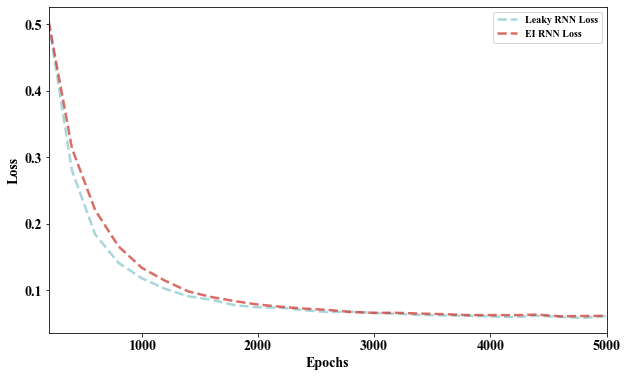

In [ ]:
print(len(Leaky_RNN_loss_values))
print(len(loss_values))

epoch = np.linspace(200, 5000,len(Leaky_RNN_loss_values))

plt.figure(figsize=(10, 6))
plt.plot(epoch, Leaky_RNN_loss_values, label='Leaky RNN Loss', linewidth=2.5, color='#84c5cb', linestyle='--', alpha=0.7)
plt.plot(epoch, loss_values, label='EI RNN Loss', linewidth=2.5, color='#cb3127', linestyle='--', alpha=0.7)


plt.xlabel('Epochs', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel('Loss', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.legend(fontsize=14, loc='upper right', prop={'weight': 'bold', 'family': 'Times New Roman'})
plt.xticks(fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.grid(False)
plt.xlim([200, 5000])


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\loss_plot_task1.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

Starting analysising the network 

In [ ]:

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
num_trial = 5000
#num_trial = 2
# EI_RNN net execution
ei_perf = 0
ei_activity_dict = {}
ei_trial_infos = {}
ei_stim_activity = [[], []]  
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    ei_action_pred, ei_rnn_activity = EI_RNN(inputs) 
 
    # Compute performance for EI_RNN
    ei_action_pred = ei_action_pred.detach().numpy()
    ei_choice = np.argmax(ei_action_pred[-1, 0, :])
    ei_correct = ei_choice == gt[-1]

    # Log trial info for EI_RNN
    ei_trial_info = env.trial
    ei_trial_info.update({'correct': ei_correct, 'choice': ei_choice})
    ei_trial_infos[i] = ei_trial_info

    # Log stimulus period activity for EI_RNN
    
    ei_rnn_activity = ei_rnn_activity[:, 0, :].detach().numpy()
    
    ei_activity_dict[i] = ei_rnn_activity

    # Compute stimulus selectivity for EI_RNN
    ei_rnn_activity = ei_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    ei_stim_activity[env.trial['ground_truth']].append(ei_rnn_activity)

print('Average performance for EI_RNN:', np.mean([val['correct'] for val in ei_trial_infos.values()]))


Average performance for EI_RNN: 0.8526


In [ ]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})


leaky_perf = 0
leaky_activity_dict = {}
leaky_trial_infos = {}
leaky_stim_activity = [[], []]  
num_trial = 5000
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    leaky_action_pred, leaky_rnn_activity, pool_hidden_test = Leaky_RNN(inputs)  

    # Compute performance for Leaky_RNN
    leaky_action_pred = leaky_action_pred.detach().numpy()
    leaky_choice = np.argmax(leaky_action_pred[-1, 0, :])
    leaky_correct = leaky_choice == gt[-1]

    # Log trial info for Leaky_RNN
    leaky_trial_info = env.trial
    leaky_trial_info.update({'correct': leaky_correct, 'choice': leaky_choice})
    leaky_trial_infos[i] = leaky_trial_info

    # Log stimulus period activity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[:, 0, :].detach().numpy()
    leaky_activity_dict[i] = leaky_rnn_activity

    # Compute stimulus selectivity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]  
    leaky_stim_activity[env.trial['ground_truth']].append(leaky_rnn_activity)

print('Average performance for Leaky_RNN:', np.mean([val['correct'] for val in leaky_trial_infos.values()]))

Average performance for Leaky_RNN: 0.8492


Processing EI_RNN...


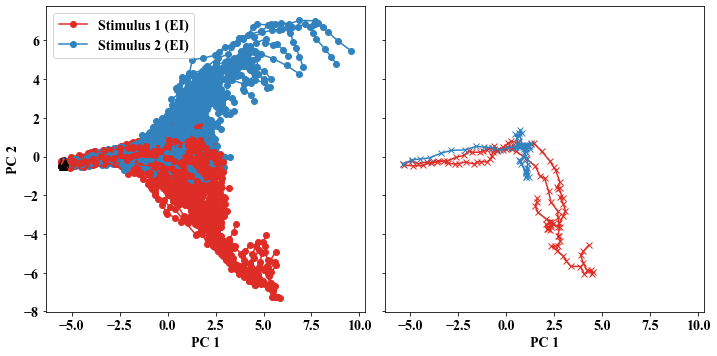

In [ ]:

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  # Basically plot all 


print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity)  
ei_activity_pc = ei_pca.transform(ei_activity)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    ei_activity_pc = ei_pca.transform(ei_activity_dict[i])
    
    trial = ei_trial_infos[i]
    color = '#de2d26' if trial['ground_truth'] == 0 else '#3182bd'

    ax1.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'o-', color=color, label='Stimulus 1 (EI)' if trial['ground_truth'] == 0 else 'Stimulus 2 (EI)')
    
    if i < 3:

        ax2.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'x-', color=color)


    ax1.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()



unique_handles_labels = dict(zip(labels, handles))  

ordered_labels = ['Stimulus 1 (EI)', 'Stimulus 2 (EI)']
ordered_handles = [unique_handles_labels[label] for label in ordered_labels]

ax1.legend(ordered_handles, ordered_labels, loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 14, 'family': 'Times New Roman'})



ax1.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel('PC 2', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')


plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task1_plot_a_PCA.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing EI_RNN...


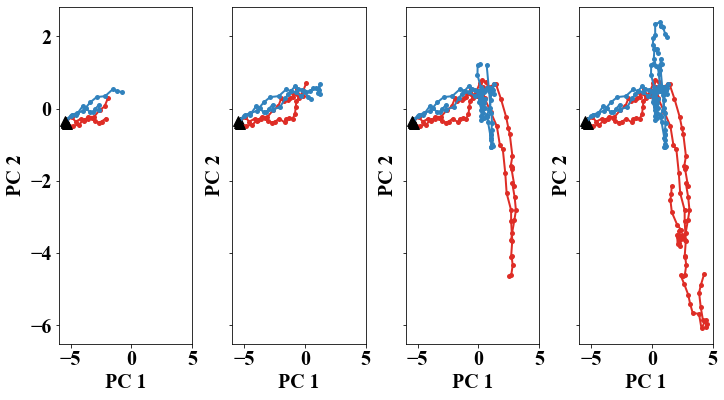

In [ ]:
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  


print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity) 
ei_activity_pc = ei_pca.transform(ei_activity)

time_intervals = [10, 20, 40, plot_until_time]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True) 

plot_indices = [0, 1, 2, 15]

for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices:  
        ei_activity_pc = ei_pca.transform(ei_activity_dict[i])

        trial = ei_trial_infos[i]
        color = '#de2d26' if trial['ground_truth'] == 0 else '#3182bd'

        ax.plot(ei_activity_pc[:time_end, 0], ei_activity_pc[:time_end, 1], 'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)
        ax.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='k', markersize=10)  

    ax.set_xlabel('PC 1', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel('PC 2', fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task1_plot_b_PCA.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...
Leaky_RNN Neural Activity Shape: (27500, 50)
Leaky_RNN Projected Activity Shape: (27500, 2)


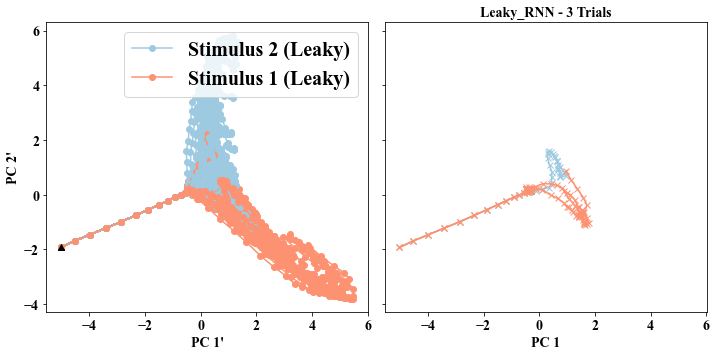

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  


print("Processing Leaky_RNN...")
leaky_activity_all = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)
print('Leaky_RNN Neural Activity Shape:', leaky_activity_all.shape)

leaky_pca_model = PCA(n_components=2)
leaky_pca_model.fit(leaky_activity_all)
leaky_activity_projected = leaky_pca_model.transform(leaky_activity_all)
print('Leaky_RNN Projected Activity Shape:', leaky_activity_projected.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    leaky_activity_per_trial = leaky_pca_model.transform(leaky_activity_dict[i])
    trial_info = leaky_trial_infos[i]
    color = '#fc9272' if trial_info['ground_truth'] == 0 else '#9ecae1'

    ax1.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
             'o-', color=color, label='Stimulus 1 (Leaky)' if trial_info['ground_truth'] == 0 else 'Stimulus 2 (Leaky)')
    
    if i < 3:
        ax2.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
                 'x-', color=color)


    ax1.plot(leaky_activity_per_trial[0, 0], leaky_activity_per_trial[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()

#print(unique_handles_labels.keys())
unique_handles_labels = dict(zip(labels, handles)) 
ax1.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 20, 'family': 'Times New Roman'})

ax2.set_title('Leaky_RNN - 3 Trials', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_xlabel("PC 1'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel("PC 2'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task1_plot_a_PCA.png"
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...


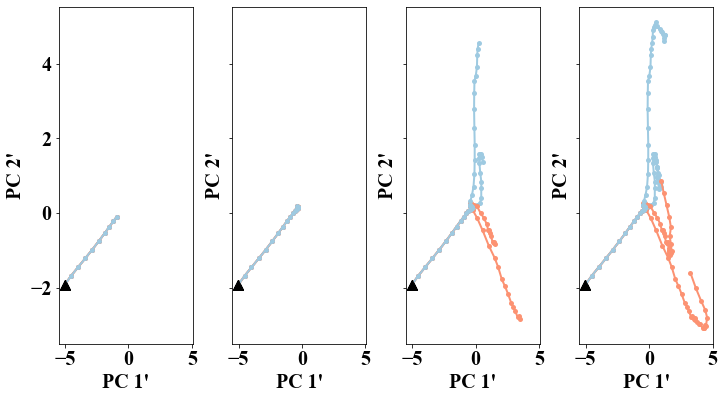

In [ ]:
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  


print("Processing Leaky_RNN...")
leaky_activity = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)

leaky_pca = PCA(n_components=2)
leaky_pca.fit(leaky_activity)  
leaky_activity_pc = leaky_pca.transform(leaky_activity)

time_intervals = [10, 20, 40, plot_until_time]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True)  

#plot_indices = [0, 1, 4, 15] 
plot_indices = [0,1,4,5] 


for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices:  
        leaky_activity_pc = leaky_pca.transform(leaky_activity_dict[i])

        trial = leaky_trial_infos[i]
        color = '#fc9272' if trial['ground_truth'] == 0 else '#9ecae1' 

        ax.plot(leaky_activity_pc[:time_end, 0], leaky_activity_pc[:time_end, 1], 
                'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)  


        ax.plot(leaky_activity_pc[0, 0], leaky_activity_pc[0, 1], '^', color='k', markersize=10)

    ax.set_xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task1_plot_b_PCA.png"
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Lesioning the network

In [ ]:
#for EI
e_size = EI_RNN.rnn.e_size 

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(ei_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0)) 
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size)) # adding e_size to make the selection in the absolute frame of reference 

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * EI_RNN.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = EI_RNN.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(EI_RNN, selective_neurons)


loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating EI_RNN after lesioning top 20% of neurons...')
for i in range(300): 
    inputs, labels = dataset()  
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)  

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):  
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
EI_RNN.rnn.h2h.weight = nn.Parameter(initial_weights)

(62025, 50)
(62975, 50)
Evaluating EI_RNN after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.3219


###Fix point 

In [ ]:
import sys
sys.path.append(r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\fixed-point-finder")

from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

In [ ]:

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first 
        #print(batch_first.shape)

    def forward(self, input, hidden):

        hidden = hidden.squeeze(0)

        output, hidden = self.rnn(input, hidden)

        hidden = hidden.unsqueeze(0)

        return None, hidden

In [ ]:
# For the EI net 

rnn_model_fixed_point = FixedPointRNNWrapper(EI_RNN.rnn, batch_first=False)

finder = FixedPointFinder(rnn_model_fixed_point) 
# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(100, EI_RNN.rnn.hidden_size)  # 100 random initial hidden states size [10, hidden  space]
print(initial_conditions.shape)
inputs = torch.zeros(100, EI_RNN.rnn.input_size)  # Zero input for each initial condition
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()


fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)


fps = fixed_points_result[0]  


fixed_points = fps.xstar  

torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.81e-01 +/- 3.66e-02
		dq = 4.63e-02 +/- 3.73e-02
		learning rate = 1.97e-07
		avg iter time = 1.24e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



(275000, 50)
(100, 50)


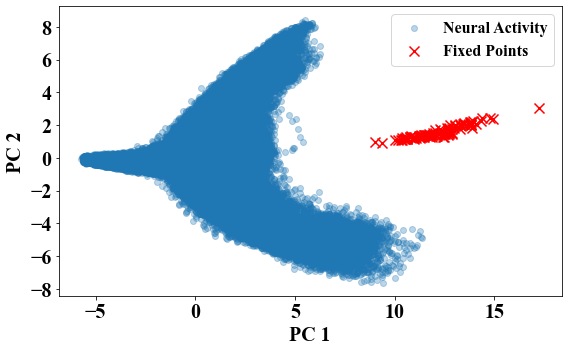

In [ ]:
# Collect activity from all trials
activity_list = []
for trial_activity in ei_activity_dict.values():
    activity_list.append(trial_activity)  
activity = np.vstack(activity_list)  


fixed_points_array = np.vstack(fixed_points) 


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 
pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)


activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)


plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.legend(
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'  
)

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task1_plot_fp_PCA.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 2.26e-01 +/- 4.85e-02
		dq = 5.51e-02 +/- 4.94e-02
		learning rate = 1.97e-07
		avg iter time = 1.04e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.72e-01 +/- 3.77e-02
		dq = 4.55e-02 +/- 3.98

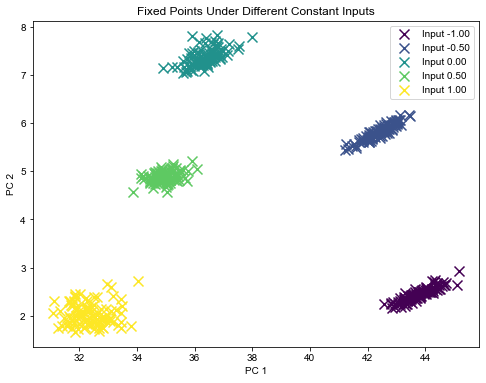

In [ ]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.input_size), input_val)  


    init_hidden_np = initial_conditions.cpu().numpy()


    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))


plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input): 

    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()


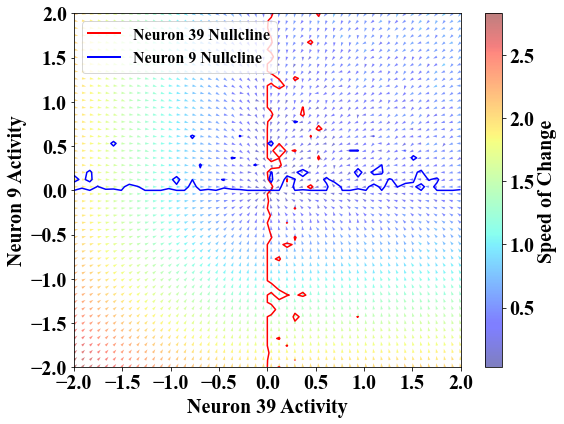

In [ ]:
from matplotlib.lines import Line2D
selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices


n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)


grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]


inputs = torch.zeros(grid_states.shape[0], EI_RNN.input_size).type(torch.float32)

initial_states = np.zeros((grid_states.shape[0], EI_RNN.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]


initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)


_, next_states = EI_RNN.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()


d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]


d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)


U = d_neuron1_grid  
V = d_neuron2_grid  


speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed


plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)


legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]

plt.legend(
    handles=legend_elements,
    loc='upper left',  
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task1_plot_nuclines.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [20]:
print(neuron1, neuron2)
print(selectivity)

39 9
[-0.36589122  0.35804564 -1.3802664   0.6591651  -1.4633896  -1.2579585
 -1.1592106   1.3504457  -0.53466386 -1.516355    0.48188326  1.3669173
  1.0354763  -1.0414296  -1.1161895  -0.02621081 -0.1363887   0.7185909
 -0.24196878  1.3359252  -1.0729891   0.92248833  1.0010252  -0.4997634
  1.3674403  -1.4449292  -1.2340231   0.95767856  0.8850896   1.0937741
 -1.3924186   0.03550289  0.9158303   0.05113453  0.9719909  -0.05560822
  1.436302   -1.2630274  -0.4038909   1.5002396  -0.09724088  0.59255683
 -0.9509928   0.21364339 -1.3933784  -0.7888534   0.77472836 -1.3500552
  1.3263775   0.06703812]


In [ ]:
#for leaky RNN lession
e_size_Leaky_RNN = Leaky_RNN.e_size  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(leaky_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size))

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * Leaky_RNN.rnn.hidden_size)  
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  


def lesion_network(net, selective_neurons):
    with torch.no_grad(): 
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0


initial_weights = Leaky_RNN.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(Leaky_RNN, selective_neurons)


loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating Leaky_RNN after lesioning top 20% of neurons...')
for i in range(300):  
    inputs, labels = dataset() 
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

  
    optimizer_Leaky_RNN.zero_grad()

 
    output, activity,_ = Leaky_RNN(inputs)
    output = output.view(-1, output_size)


    loss = criterion(output, labels) 

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1): 
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0


Leaky_RNN.rnn.h2h.weight = nn.Parameter(initial_weights)

(62875, 50)
(62125, 50)
Evaluating Leaky_RNN after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.1003


In [ ]:
#repeat for the leaky

Leaky_rnn_model_fixed_point = FixedPointRNNWrapper(Leaky_RNN.rnn, batch_first=False)


leaky_finder = FixedPointFinder(Leaky_rnn_model_fixed_point) 


initial_conditions = torch.randn(100, Leaky_RNN.rnn.hidden_size)  
print(initial_conditions.shape)
inputs = torch.zeros(100, Leaky_RNN.rnn.input_size) 
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()


fixed_points_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)


fps = fixed_points_result[0]  


fixed_points = fps.xstar  

torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		793 iters
		q = 1.97e-13 +/- 1.55e-13
		dq = 7.77e-14 +/- 9.14e-14
		learning rate = 2.04e-01
		avg iter time = 8.60e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



(1, 50)
(275000, 50)
(1, 50)


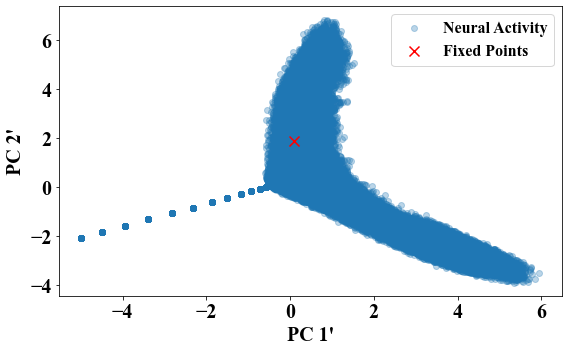

In [ ]:
activity_list = []
for trial_activity in leaky_activity_dict.values():
    activity_list.append(trial_activity)  
activity = np.vstack(activity_list)  


fixed_points_array = np.vstack(fixed_points)  


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 


print(fixed_points_array.shape)

pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

#
save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task1_plot_fp_PCA.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		532 iters
		q = 3.99e-13 +/- 1.60e-13
		dq = 1.38e-13 +/- 1.15e-13
		learning rate = 2.15e-01
		avg iter time = 1.08e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1329 iters
		q = 5.92e-13 +/- 1.66e-13
		dq = 1.71e-13 +/- 1.23e-13
		learni

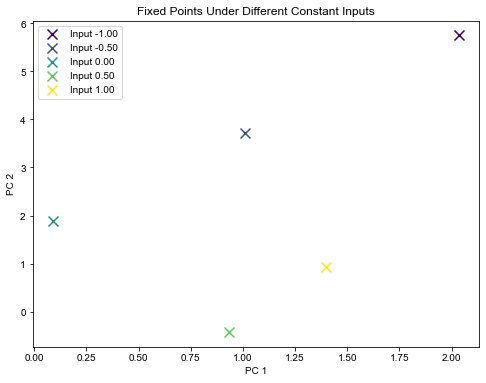

In [ ]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.input_size), input_val)  

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))


plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input): 

    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()

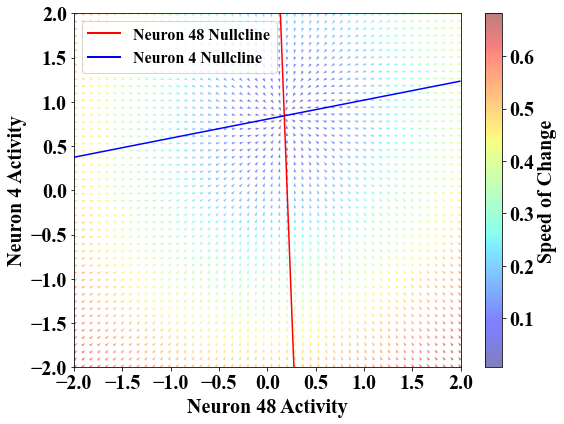

In [25]:
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

inputs = torch.zeros(grid_states.shape[0], EI_RNN.input_size).type(torch.float32)


initial_states = np.zeros((grid_states.shape[0], EI_RNN.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]


initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)


_, next_states = Leaky_RNN.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()


d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]


d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)


U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed


plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)


legend_elements = [
    Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
    Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')
]


plt.legend(
    handles=legend_elements,
    loc='upper left',
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task1_plot_nuclines.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [26]:
print(neuron1, neuron2)
print(selectivity)

48 4
[ 6.8922555e-01  1.3992838e+00  0.0000000e+00  7.6250494e-01
  1.7387592e+00 -1.5324398e+00 -1.4532348e+00  1.4559620e-06
  1.4312508e+00  1.4514377e+00  1.5975599e+00  1.5027051e+00
  1.3198540e+00  1.0428480e+00  1.3149621e+00  0.0000000e+00
  1.0366489e+00  1.5427203e+00 -7.5409609e-01  1.6344891e+00
 -5.3442228e-01 -1.5791600e+00 -1.0348421e+00  0.0000000e+00
  0.0000000e+00  1.4452213e+00  2.6955193e-02  1.5223552e+00
  0.0000000e+00 -1.4503433e+00  1.9259559e-01 -9.0025014e-01
 -1.4480902e+00 -7.5295311e-01 -4.5101830e-01 -1.3694850e+00
  4.8164475e-01 -1.5129915e+00 -1.4213489e+00 -1.3540347e-01
  3.6438459e-01 -1.3020091e+00 -4.5084983e-01 -1.5225879e+00
  0.0000000e+00 -9.1838250e-03 -1.6028545e+00  0.0000000e+00
  1.6601934e+00  0.0000000e+00]
